In [1]:
cd ../src

/home/richard/Desktop/software/upload/epicluster-results/src


In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import copy
import scipy.stats
import branchpro
import epicluster as ec

In [3]:
random.seed(123)
np.random.seed(123)

In [4]:
branchpro7_means = []
branchpro28_means = []
epifilter_means = []
nonp_means = []

for i in range(10):

    # serial interval
    w = scipy.stats.gamma(2.707, scale=1/0.177)
    w = w.pdf(np.arange(50))
    w = w / sum(w)


    # data
    data = pd.read_csv("../data/synthetic/ebola_seed{}.csv".format(i))
    Rt_series = np.asarray(data['Rt'])
    cases = np.asarray(data['cases'])

    past_cases = np.ones(len(w)) * 5
    inf_cases = np.concatenate([past_cases, cases])



    # run branchpro
    a = 1
    b = 5

    inc_data = pd.DataFrame(
        {
            'Time': np.arange(len(inf_cases)),
            'Incidence Number': inf_cases
        }
    )

    inference = branchpro.BranchProPosterior(
        inc_data=inc_data,
        daily_serial_interval=w,
        alpha=a,
        beta=1/b)

    inference.run_inference(tau=7)
    intervals7 = inference.get_intervals(central_prob=.9)

    inference.run_inference(tau=28)
    intervals28 = inference.get_intervals(central_prob=.9)


    # run change point
    p = ec.PoissonModel(copy.deepcopy(inf_cases), w, prior_expected_clusters=1.5)
    mcmc = ec.MCMCSampler(p, 4)
    phi_chain, z_chain, counts = mcmc.run_mcmc(Rhat_thresh=1.05, progress=True)


    Rs = []
    num_mcmc = len(z_chain)
    for phi, z in zip(phi_chain[num_mcmc//2:], z_chain[num_mcmc//2:]):
        Rs.append([phi[zi] for zi in z])

    # load epifilter
    epi_results = pd.read_csv('../data/synthetic/results/ebola/ebola_{}.csv'.format(i))


    # save results
    branchpro7_means.append(intervals7['Mean'][len(w):])
    branchpro28_means.append(intervals28['Mean'][len(w):])
    epifilter_means.append(epi_results['R_smooth'][1:])
    nonp_means.append(np.mean(Rs, axis=0))
    

Iter=50, Rhat=112.92205506422485
Iter=100, Rhat=52.69522184851589
Iter=150, Rhat=34.958833602037636
Iter=200, Rhat=22.060326542816437
Iter=250, Rhat=17.200839189823338
Iter=300, Rhat=12.863688095611728
Iter=350, Rhat=11.325228036237007
Iter=400, Rhat=9.090420856442758
Iter=450, Rhat=7.2782266587823825
Iter=500, Rhat=6.026453669530831
Iter=550, Rhat=5.099373359989736
Iter=600, Rhat=3.981514686165503
Iter=650, Rhat=3.3379283843805028
Iter=700, Rhat=3.161910326917036
Iter=750, Rhat=2.8774990093022508
Iter=800, Rhat=2.4497483540176757
Iter=850, Rhat=1.929731062194333
Iter=900, Rhat=1.611255266201917
Iter=950, Rhat=1.4256963350799055
Iter=1000, Rhat=1.3116419569549065
Iter=1050, Rhat=1.2318857804920467
Iter=1100, Rhat=1.1802775575028963
Iter=1150, Rhat=1.1389131506022805
Iter=1200, Rhat=1.1082834677805702
Iter=1250, Rhat=1.0899137837222133
Iter=1300, Rhat=1.070228384417728
Iter=1350, Rhat=1.0514734845110145
Iter=1400, Rhat=1.0530823445324684
Iter=1450, Rhat=1.064936628948969
Iter=1500, Rhat

Iter=900, Rhat=1.648599906688571
Iter=950, Rhat=1.4250647887396939
Iter=1000, Rhat=1.2973637984933974
Iter=1050, Rhat=1.2130044484996543
Iter=1100, Rhat=1.1564285293906598
Iter=1150, Rhat=1.1089011252735728
Iter=1200, Rhat=1.068958278866423
Iter=1250, Rhat=1.0403165932590155
Converged 1250 1.0403165932590155
Iter=50, Rhat=87.92393443131093
Iter=100, Rhat=59.27483862067019
Iter=150, Rhat=33.627127325587416
Iter=200, Rhat=23.957506947769254
Iter=250, Rhat=15.559101163806716
Iter=300, Rhat=13.186480412489601
Iter=350, Rhat=9.66201439065137
Iter=400, Rhat=8.732416767352607
Iter=450, Rhat=7.073794107905416
Iter=500, Rhat=5.958611857857279
Iter=550, Rhat=4.9148978400497425
Iter=600, Rhat=4.150938085100771
Iter=650, Rhat=3.383226141152989
Iter=700, Rhat=3.0654048509189424
Iter=750, Rhat=2.9013198373709437
Iter=800, Rhat=2.7193893445606436
Iter=850, Rhat=2.20138251696414
Iter=900, Rhat=1.769988750630767
Iter=950, Rhat=1.5096731079461332
Iter=1000, Rhat=1.3641831665411328
Iter=1050, Rhat=1.2684

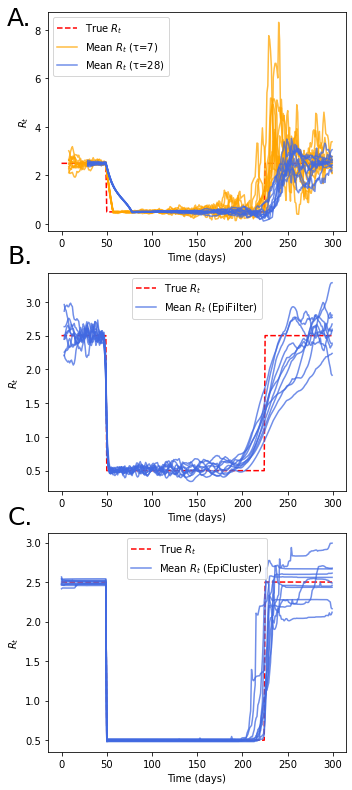

In [5]:
fig = plt.figure(figsize=(5,11))


ax = fig.add_subplot(3, 1, 1)

x = np.arange(len(cases))
ax.plot(x, Rt_series, color='red', label='True $R_t$', ls='--')

for i, mean in enumerate(branchpro7_means):
    x = np.arange(8, len(cases))
    ax.plot(x, mean, color='orange', alpha=0.75, label='Mean $R_t$ (τ=7)' if i==0 else None)
    
for i, mean in enumerate(branchpro28_means):
    x = np.arange(29, len(cases))
    ax.plot(x, mean, color='royalblue', alpha=0.75, label='Mean $R_t$ (τ=28)' if i==0 else None)
ax.legend()
ax.set_xlabel('Time (days)')
ax.set_ylabel('$R_t$')


ax = fig.add_subplot(3, 1, 2)
x = np.arange(len(cases))
ax.plot(x, Rt_series, color='red', label='True $R_t$', ls='--')

for i, mean in enumerate(epifilter_means):
    x = epi_results['day'][1:]
    ax.plot(x, mean, color='royalblue', alpha=0.75, label='Mean $R_t$ (EpiFilter)' if i==0 else None)
ax.legend()
ax.set_xlabel('Time (days)')
ax.set_ylabel('$R_t$')


ax = fig.add_subplot(3, 1, 3)
x = np.arange(len(cases))
ax.plot(x, Rt_series, color='red', label='True $R_t$', ls='--')

for i, mean in enumerate(nonp_means):
    x = np.arange(len(cases))
    ax.plot(x, mean, color='royalblue', alpha=0.75, label='Mean $R_t$ (EpiCluster)' if i==0 else None)

ax.legend()
ax.set_xlabel('Time (days)')
ax.set_ylabel('$R_t$')



fig.set_tight_layout(True)

plt.subplots_adjust(left=0.2)
fig.text(.03, .97, 'A.', fontsize=25)
fig.text(.03, .67, 'B.', fontsize=25)
fig.text(.03, .34, 'C.', fontsize=25)

plt.savefig('../notebooks/FigureS3.pdf')
plt.show()
